In [4]:
from math import e as EXP
STATE_LIMIT = 20
state_space = [(i, j) for i in range(STATE_LIMIT + 1)
                      for j in range(STATE_LIMIT + 1)]

mdp = {s: {} for s in state_space}
df = 0.9
actions = list(range(-5, 6))
RENT_A, RENT_B = 3, 4
RET_A, RET_B = 3, 2

fact_table = [1] * 21
for i in range(1, 21):
    fact_table[i] = fact_table[i - 1] * i
MAX_POISSON = 10
poisson_table = {}

for lam in {RENT_A, RENT_B, RET_A, RET_B}:
    probs = [0.0] * (MAX_POISSON + 1)
    base = EXP ** (-lam)

    for k in range(MAX_POISSON):
        probs[k] = (lam ** k / fact_table[k]) * base

    probs[MAX_POISSON] = 1 - sum(probs[:MAX_POISSON])
    poisson_table[lam] = probs
def not_converged(prev, curr, eps):
    return max(abs(curr[s] - prev[s]) for s in prev) > eps

In [ ]:
for state in state_space:
    transitions = {}

    for move in actions:
        if move > state[0]:
            transitions[move] = [(0.0, state, 0.0)]
            continue
        elif -move > state[1]:
            transitions[move] = [(0.0, state, 0.0)]
            continue
        post_move = [
            min(state[0] - move, STATE_LIMIT),
            min(state[1] + move, STATE_LIMIT)
        ]
        if post_move[0] < 0 or post_move[1] < 0:
            continue
        outcome_accumulator = {}
        for rA in range(MAX_POISSON + 1):
            for rB in range(MAX_POISSON + 1):
                for tA in range(MAX_POISSON + 1):
                    for tB in range(MAX_POISSON + 1):
                        realA = min(rA, post_move[0])
                        realB = min(rB, post_move[1])
                        next_state = (
                            max(0, min(post_move[0] - realA + tA, STATE_LIMIT)),
                            max(0, min(post_move[1] - realB + tB, STATE_LIMIT))
                        )
                        prob = (
                            poisson_table[RENT_A][rA] *
                            poisson_table[RENT_B][rB] *
                            poisson_table[RET_A][tA] *
                            poisson_table[RET_B][tB]
                        )
                        reward = -2 * abs(move) + 10 * (realA + realB)
                        if next_state not in outcome_accumulator:
                            outcome_accumulator[next_state] = [0.0, 0.0]
                        outcome_accumulator[next_state][0] += prob
                        outcome_accumulator[next_state][1] += prob * reward
        transition_list = []
        for ns, (p, r_sum) in outcome_accumulator.items():
            if p > 0:
                transition_list.append((p, ns, r_sum / p))
        transitions[move] = transition_list
    mdp[state] = transitions

In [8]:
import numpy as np
import matplotlib.pyplot as plt

V = {s: 10.0 for s in state_space}
V_next = {s: 0.0 for s in state_space}

policy = {s: 0 for s in state_space}
policy_prev = {s: 5 for s in state_space}

epsilon = 1e-4
iteration_count = 0

while policy != policy_prev:
    iteration_count += 1
    policy_prev = policy.copy()

    for s in state_space:
        V[s] = 10.0
        V_next[s] = 0.0
    while not_converged(V, V_next, epsilon):
        V = V_next.copy()
        for s in state_space:
            val = 0.0
            for p, s2, r in mdp[s][policy[s]]:
                val += p * (r + df * V[s2])
            V_next[s] = val
    for s in state_space:
        best_action = None
        best_value = -float("inf")

        for a in actions:
            q = 0.0
            for p, s2, r in mdp[s][a]:
                q += p * (r + df * V_next[s2])

            if q > best_value:
                best_value = q
                best_action = a

        policy[s] = best_action

print(iteration_count)

5


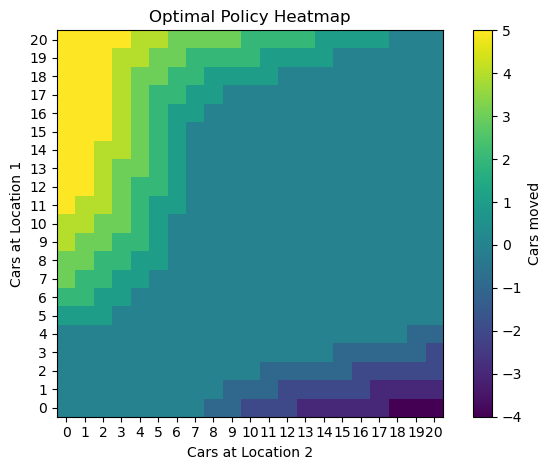

In [9]:
policy_grid = np.zeros((21, 21))
for (x, y), a in policy.items():
    policy_grid[x, y] = a
plt.imshow(policy_grid, origin="lower", cmap="viridis")
plt.colorbar(label="Cars moved")
plt.xlabel("Cars at Location 2")
plt.ylabel("Cars at Location 1")
plt.title("Optimal Policy Heatmap")
plt.xticks(range(21))
plt.yticks(range(21))
plt.tight_layout()
plt.show()

In [10]:
for s in state_space:
    V[s] = 10.0
    V_next[s] = 0.0
while not_converged(V, V_next, epsilon):
    V = V_next.copy()
    for s in state_space:
        total = 0.0
        for p, s2, r in mdp[s][policy[s]]:
            total += p * (r + df * V[s2])
        V_next[s] = total
print(V_next)

{(0, 0): 421.3938273034232, (0, 1): 431.3660504153896, (0, 2): 441.22175100136764, (0, 3): 450.82710200029277, (0, 4): 460.0599702176654, (0, 5): 468.8521760533588, (0, 6): 477.19063013234864, (0, 7): 485.094468904799, (0, 8): 492.95777191727814, (0, 9): 500.45357690636536, (0, 10): 507.86568169605, (0, 11): 514.9711769873597, (0, 12): 521.7279572565346, (0, 13): 528.3282624811033, (0, 14): 534.716839481086, (0, 15): 540.8033817783008, (0, 16): 546.6061546870217, (0, 17): 552.1414892011142, (0, 18): 557.5656378884919, (0, 19): 562.7682967078298, (0, 20): 567.7176151079859, (1, 0): 431.267583457099, (1, 1): 441.23974036375984, (1, 2): 451.09511242891426, (1, 3): 460.6996208576594, (1, 4): 469.93098528919785, (1, 5): 478.721059411884, (1, 6): 487.0568994542536, (1, 7): 494.95777191727825, (1, 8): 502.4535769063653, (1, 9): 509.86568169605005, (1, 10): 516.9711769873595, (1, 11): 523.7279572565344, (1, 12): 530.3282624811036, (1, 13): 536.7168394810861, (1, 14): 542.8033817783011, (1, 15)